In [411]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.layers import Dense, Conv2D, Flatten, Reshape, Conv2DTranspose
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
import umap.umap_ as umap
# import hdbscan

In [412]:
input_spe = (32, 32, 1)
latent_dim = 100

In [413]:
images = np.load('D:/magist/semestr 2/UczNienadwz/UNN/datasets/n0_b0_r0_s0/dataset_n0_b0_r0_s0.npy')

x_data, y_data = images[:, 0, :, :], images[:, 1, :, :]
x_data, y_data = np.expand_dims(x_data, -1).astype("float32") / 255, np.expand_dims(y_data, -1).astype("float32") / 255
x_data.shape

(36480, 32, 32, 1)

In [414]:
# X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2, random_state = 42, shuffle = True)
# print("               X               Y")
# print("train", X_train.shape, "  ", y_train.shape)
# print(" test", X_test.shape, "   ", y_test.shape)
#
# print("\nTrain: ", X_train.shape[0], "samples")
# print("Test:  ", X_test.shape[0], "samples")
X_train = x_data

## sampling layer + Encoder + Decoder + VAE

In [415]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        mean, log_var = inputs
        epsilon = tf.keras.backend.random_normal(shape = tf.shape(mean), mean = 0., stddev = 1.)
        return mean + tf.exp(log_var / 2) * epsilon


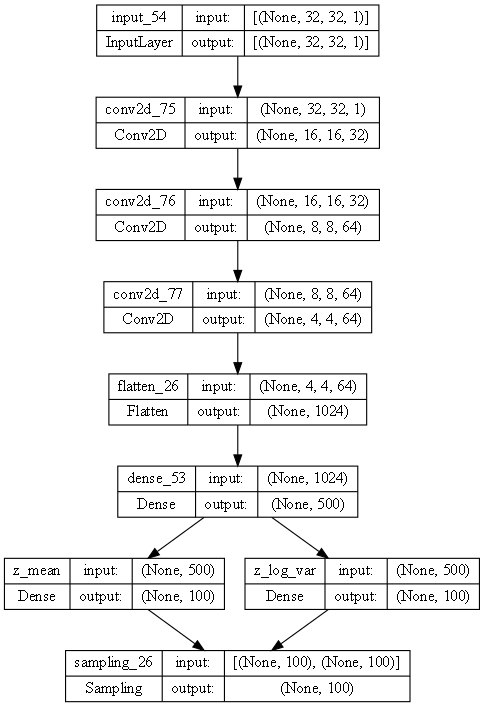

In [416]:
encoder_inputs = keras.Input(shape = input_spe)

x = Conv2D(32, 3, activation = "relu", strides = 2, padding = "same")(encoder_inputs)
x = Conv2D(64, 3, activation = "relu", strides = 2, padding = "same")(x)
x = Conv2D(64, 3, activation = "relu", strides = 2, padding = "same")(x)

x = Flatten()(x)
x = Dense(500, activation = "relu")(x)
z_mean = Dense(latent_dim, name = "z_mean")(x)
z_log_var = Dense(latent_dim, name = "z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name = "encoder")
encoder.summary()
plot_model(encoder, show_shapes = True, dpi = 80)

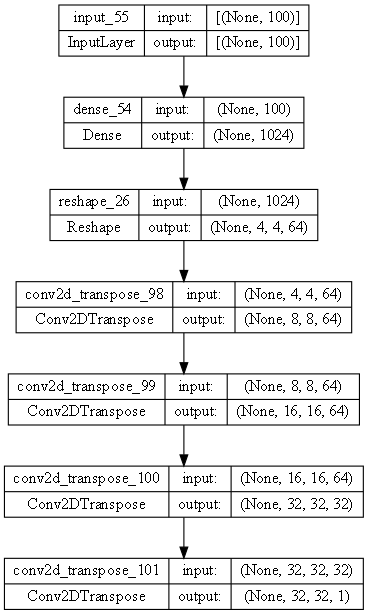

In [417]:
latent_inputs = keras.Input(shape = (latent_dim,))

x = Dense(4 * 4 * 64, activation = "relu")(latent_inputs)
x = Reshape((4, 4, 64))(x)

x = Conv2DTranspose(64, 3, activation = "relu", strides = 2, padding = "same")(x)
x = Conv2DTranspose(64, 3, activation = "relu", strides = 2, padding = "same")(x)
x = Conv2DTranspose(32, 3, activation = "relu", strides = 2, padding = "same")(x)
decoder_outputs = Conv2DTranspose(1, 3, activation = "sigmoid", padding = "same")(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name = "decoder")
plot_model(decoder, show_shapes = True, dpi = 80)

In [418]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name = "total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name = "reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name = "kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker, ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction), axis = (1, 2)))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis = 1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {"loss": self.total_loss_tracker.result(), "reconstruction_loss": self.reconstruction_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result(), }

## Train the VAE

In [419]:
vae = VAE(encoder, decoder)
vae.compile(optimizer = keras.optimizers.Adam())

In [420]:
history = vae.fit(X_train, epochs = 5, batch_size = 126)
history.history.keys()

Epoch 1/5
290/290 [==============================] - 43s 132ms/step - loss: 179.0314 - reconstruction_loss: 88.8543 - kl_loss: 5.6538
Epoch 2/5
290/290 [==============================] - 36s 124ms/step - loss: 55.5690 - reconstruction_loss: 48.6598 - kl_loss: 5.7176
Epoch 3/5
290/290 [==============================] - 34s 118ms/step - loss: 49.4739 - reconstruction_loss: 39.3943 - kl_loss: 7.7056
Epoch 4/5
290/290 [==============================] - 33s 113ms/step - loss: 42.1260 - reconstruction_loss: 32.6405 - kl_loss: 8.8310
Epoch 5/5
290/290 [==============================] - 27s 95ms/step - loss: 38.7362 - reconstruction_loss: 29.1513 - kl_loss: 9.0393


dict_keys(['loss', 'reconstruction_loss', 'kl_loss'])

Text(0.5, 0, 'Epoch')

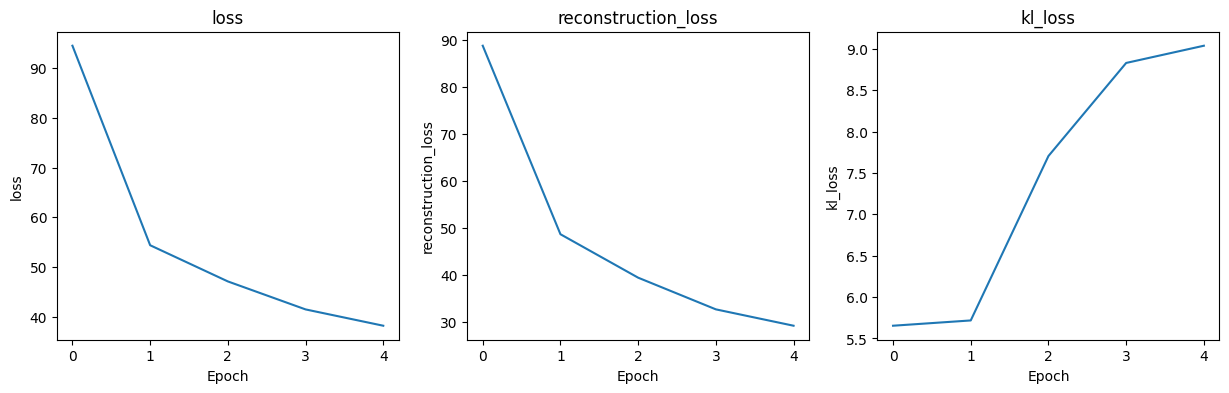

In [421]:
plt.figure(figsize = (15, 4))
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.subplot(1, 3, 2)
plt.plot(history.history['reconstruction_loss'])
plt.title('reconstruction_loss')
plt.ylabel('reconstruction_loss')
plt.xlabel('Epoch')
plt.subplot(1, 3, 3)
plt.plot(history.history['kl_loss'])
plt.title('kl_loss')
plt.ylabel('kl_loss')
plt.xlabel('Epoch')

## Test

In [428]:
m, v, embeddings = vae.encoder.predict(x_data[np.random.choice(range(len(x_data)), 10000)], verbose = 0)

In [429]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(embeddings)

d:\magist\projekty\analizaobrazow\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
d:\magist\projekty\analizaobrazow\lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


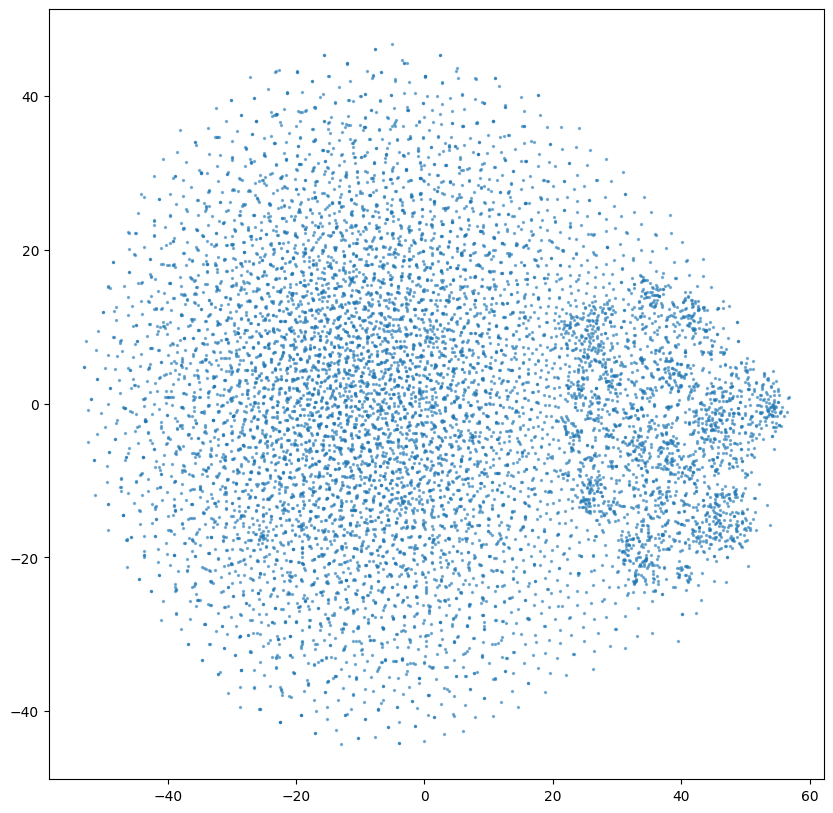

In [430]:
plt.figure(figsize=(10, 10))
plt.scatter(X_tsne[:, 0] , X_tsne[:, 1], alpha=0.5, s=2)
plt.show()

In [431]:
# for i in range():
#     for j in range(20):
#         if i > j:
#             m, v, embeddings = vae.encoder.predict(x_data[np.random.choice(range(len(x_data)), 5000)], verbose = 0)
#             plt.scatter(embeddings[:, i] , embeddings[:, j], alpha=0.5, s=1)
#             plt.title(str(i) + "+" + str(j))
#             plt.show()

In [432]:
clusterable_embedding = umap.UMAP(n_neighbors = 200,
                                  min_dist = 0.1,
                                  n_components = latent_dim,
                                  random_state = 42,
                                  n_epochs = 500)\
    .fit_transform(embeddings)
print("clusterable_embedding", clusterable_embedding.shape)

clusterable_embedding (10000, 100)


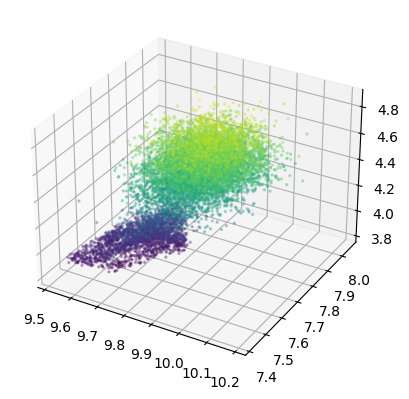

In [434]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(clusterable_embedding[:, 42],
           clusterable_embedding[:, 98],
           clusterable_embedding[:, 90],
           c =clusterable_embedding[:, 90],
           s = 2,
           alpha=0.3)
plt.show()

d:\magist\projekty\analizaobrazow\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
d:\magist\projekty\analizaobrazow\lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


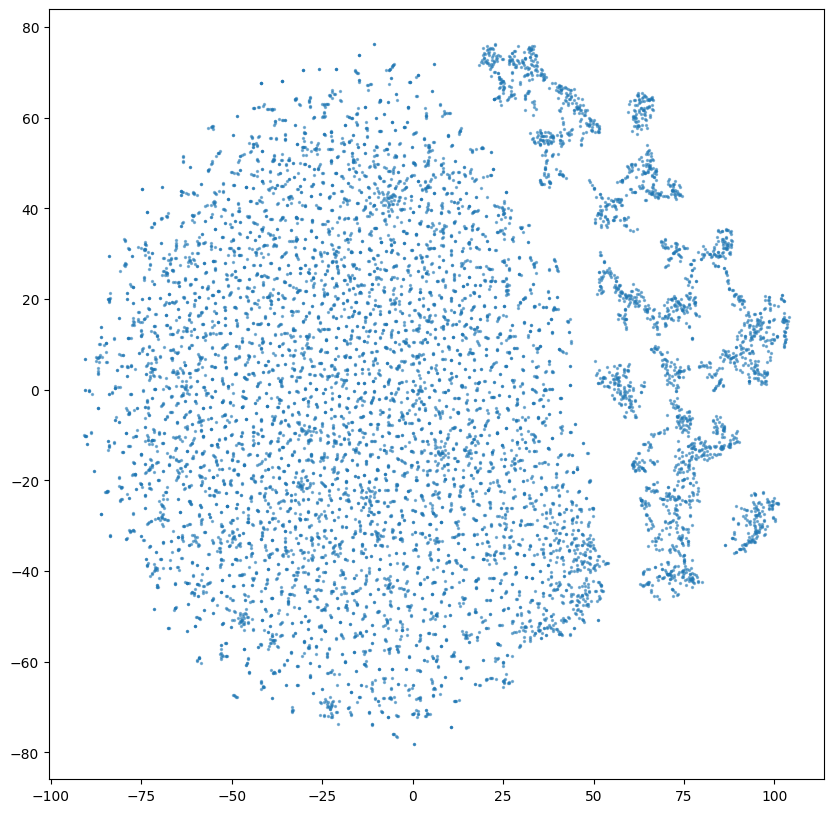

In [435]:
tsne2 = TSNE(n_components=2, init='pca', random_state=0)
X_tsne2 = tsne2.fit_transform(clusterable_embedding)
plt.figure(figsize=(10, 10))
plt.scatter(X_tsne2[:, 0] , X_tsne2[:, 1], alpha=0.5, s=2)
plt.show()